# Lesson 4: Reward functions

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code>  file:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

Start by importing dependencies:

In [1]:
from utils import *
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

Create a predibase deployment that you'll use to call the models:

In [3]:
# Uncomment the line below if running in your own environment - the deployment is already setup for you here
# create_deployment()

Specify the model to use:

In [4]:
model_id = "Qwen/Qwen2.5-7B-Instruct"

## Define a simple reward function

In [5]:
def wordle_reward(guess: str, secret_word: str) -> int: 
    if guess.upper() == secret_word.upper():
        return 1   # correct guess
    else:
        return 0   # incorrect guess

Define a secret word and get feedback on past guesses, then score the guesses using the reward function above:

In [6]:
secret_word = "POUND"

past_guesses = [
    GuessWithFeedback.from_secret(guess="CRANE", secret=secret_word),
    GuessWithFeedback.from_secret(guess="BLOND", secret=secret_word),
    GuessWithFeedback.from_secret(guess="FOUND", secret=secret_word),
]
past_guesses

[CRANE → Feedback: C(x) R(x) A(x) N(✓) E(x),
 BLOND → Feedback: B(x) L(x) O(-) N(✓) D(✓),
 FOUND → Feedback: F(x) O(✓) U(✓) N(✓) D(✓)]

In [7]:
response = generate(get_messages(past_guesses))[0]
guess = extract_guess(response)
reward = wordle_reward(guess, secret_word)

print(f"Guessed Word: {guess} -> Reward: {reward}")

Guessed Word: FOUND -> Reward: 0


## Using rewards to calculate advantages

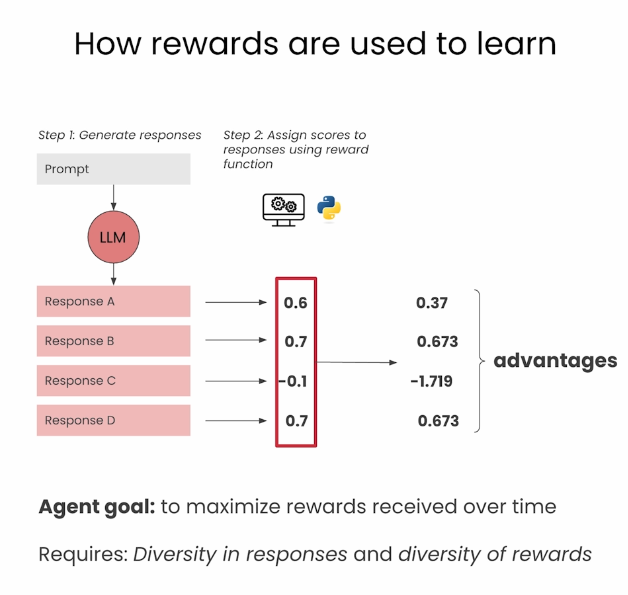

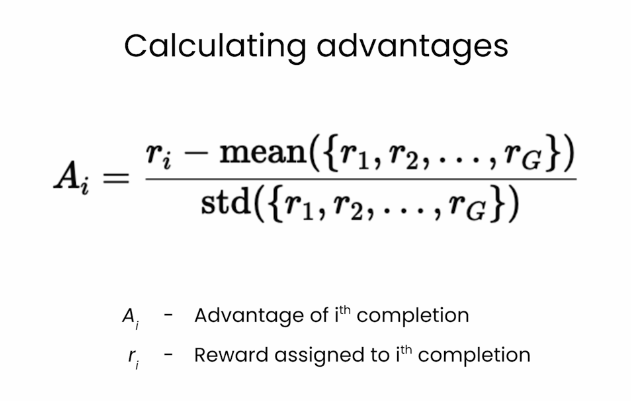

In [8]:
def compute_advantages(rewards: list):
    rewards = np.array(rewards)
    
    # Compute the mean and standard deviation of the rewards
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    # Avoid division by zero in case of zero variance (typically happens when all rewards are 0)
    # Note: In the GRPO implementation, we add 1e-4 to the std_reward to avoid division by zero
    if std_reward == 0:
        return [0] * len(rewards)

    # Divide by stddev of rewards to normalize range to 0
    advantages = (rewards - mean_reward) / std_reward
    return advantages.tolist()

In [9]:
rewards = [0.0, 0.2, 0.4, 0.5, 0.5, 0.6, 0.8, 1.0]
compute_advantages(rewards)

[-1.6903085094570331,
 -1.01418510567422,
 -0.33806170189140655,
 0.0,
 0.0,
 0.33806170189140655,
 1.0141851056742202,
 1.6903085094570331]

In [10]:
def render_guess_table(response, reward_fn): #visualize the guesses & rewards
    guesses = [extract_guess(guess) for guess in response]
    rewards = [reward_fn(guess, secret_word) for guess in guesses]
    print_guesses_table(guesses, rewards)

In [11]:
print(f"Secret: {secret_word}")
response = generate(get_messages(past_guesses), num_guesses=8)
render_guess_table(response, wordle_reward) #=> binary reward function is too stric and instead use a partial credit system

Secret: POUND
+---------+---------+----------+-------------+
|   Index | Guess   |   Reward |   Advantage |
+=========+=========+==========+=============+
|       0 | TOWN    |        0 |           0 |
+---------+---------+----------+-------------+
|       1 | RONDO   |        0 |           0 |
+---------+---------+----------+-------------+
|       2 | STONE   |        0 |           0 |
+---------+---------+----------+-------------+
|       3 | FROWN   |        0 |           0 |
+---------+---------+----------+-------------+
|       4 | FOUND   |        0 |           0 |
+---------+---------+----------+-------------+
|       5 | OUNDR   |        0 |           0 |
+---------+---------+----------+-------------+
|       6 | OUDEN   |        0 |           0 |
+---------+---------+----------+-------------+
|       7 | TOWNS   |        0 |           0 |
+---------+---------+----------+-------------+


## Update the reward function to give partial credit

In [12]:
def wordle_reward_partial_credit(guess: str, secret_word: str) -> float: # give the partial credit
    if len(guess) != len(secret_word):
        # no reward for having the wrong number of letters
        return 0.0
    
    valid_letters = set(secret_word)
    reward = 0.0
    for letter, secret_letter in zip(guess, secret_word):
        if letter == secret_letter:
            # right letter, right location
            reward += 0.2
        elif letter in valid_letters:
            # right letter, wrong location
            reward += 0.1
        else:
            # no reward
            pass
    return reward

Try scoring a set of responses using updated reward function. Start by setting <b>temperature = 0</b>

In [13]:
print(f"Secret: {secret_word}")
response = generate(get_messages(past_guesses), num_guesses=8, temperature=0)# select the highest probability guess for each prompt
render_guess_table(response, wordle_reward_partial_credit)

Secret: POUND
+---------+---------+----------+-------------+
|   Index | Guess   |   Reward |   Advantage |
+=========+=========+==========+=============+
|       0 | BONDS   |      0.4 |    0.100504 |
+---------+---------+----------+-------------+
|       1 | OUDEN   |      0.4 |    0.100504 |
+---------+---------+----------+-------------+
|       2 | ROUND   |      0.8 |    1.70856  |
+---------+---------+----------+-------------+
|       3 | TORNAD  |      0   |   -1.50756  |
+---------+---------+----------+-------------+
|       4 | TORNAD  |      0   |   -1.50756  |
+---------+---------+----------+-------------+
|       5 | BOARD   |      0.4 |    0.100504 |
+---------+---------+----------+-------------+
|       6 | DOWNY   |      0.5 |    0.502519 |
+---------+---------+----------+-------------+
|       7 | DOWNY   |      0.5 |    0.502519 |
+---------+---------+----------+-------------+


Now set temperature to a high value:

In [18]:
print(f"Secret: {secret_word}")
response = generate(get_messages(past_guesses), num_guesses=8, temperature=1.3) #more variety 
render_guess_table(response, wordle_reward_partial_credit)

Secret: POUND
+---------+---------+----------+-------------+
|   Index | Guess   |   Reward |   Advantage |
+=========+=========+==========+=============+
|       0 | BROWN   |      0.2 |   -0.729325 |
+---------+---------+----------+-------------+
|       1 |         |      0   |   -1.89624  |
+---------+---------+----------+-------------+
|       2 | DONUT   |      0.5 |    1.02105  |
+---------+---------+----------+-------------+
|       3 | NORSE   |      0.3 |   -0.145865 |
+---------+---------+----------+-------------+
|       4 | THING   |      0.2 |   -0.729325 |
+---------+---------+----------+-------------+
|       5 | ONOUN   |      0.5 |    1.02105  |
+---------+---------+----------+-------------+
|       6 | BOARD   |      0.4 |    0.437595 |
+---------+---------+----------+-------------+
|       7 | OUNDU   |      0.5 |    1.02105  |
+---------+---------+----------+-------------+


Lastly, set temperature to a moderate value of 0.7:

In [20]:
print(f"Secret: {secret_word}")
response = generate(get_messages(past_guesses), num_guesses=8, temperature=0.7)
render_guess_table(response, wordle_reward_partial_credit)

Secret: POUND
+---------+---------+----------+-------------+
|   Index | Guess   |   Reward |   Advantage |
+=========+=========+==========+=============+
|       0 | GROUND  |      0   |   -1.89737  |
+---------+---------+----------+-------------+
|       1 | RLODN   |      0.3 |    0        |
+---------+---------+----------+-------------+
|       2 | FLOUR   |      0.2 |   -0.632456 |
+---------+---------+----------+-------------+
|       3 | ROBOT   |      0.3 |    0        |
+---------+---------+----------+-------------+
|       4 | SHOUT   |      0.2 |   -0.632456 |
+---------+---------+----------+-------------+
|       5 | DONUT   |      0.5 |    1.26491  |
+---------+---------+----------+-------------+
|       6 | RONIN   |      0.4 |    0.632456 |
+---------+---------+----------+-------------+
|       7 | RONDO   |      0.5 |    1.26491  |
+---------+---------+----------+-------------+
